In [1]:
import math

import torch

from script.NeuralNets.Networks import SequentialNN, ICNN, ICNNApproxMax, ICNNLogical
from script.settings import device, data_type
import script.DHOV.MultiDHOV as multidhov
from script.Verification.Verifier import SingleNeuronVerifier, MILPVerifier, DHOVVerifier
import gurobipy as grp
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory

In [21]:
def add_max_constr(model, neuron_name):
    neuron_var = model.getVarByName(neuron_name)
    model.setObjective(neuron_var, grp.GRB.MAXIMIZE)

def add_min_constr(model, neuron):
    neuron_var = model.getVarByName(neuron)
    model.setObjective(neuron_var, grp.GRB.MINIMIZE)

In [24]:
def optimize_model(model, neuron_name):
    model.update()
    model.optimize()
    if model.Status == grp.GRB.OPTIMAL:
        print("opt value: {}".format(model.getVarByName(neuron_name).getAttr("x")))
        return model.getVarByName(neuron_name).getAttr("x")

In [4]:
def icnn_model(icnn, nn, input_x, eps, layer_index, from_neuron, to_neuron, print_log=False):
    m = grp.Model()
    if not print_log:
        m.Params.LogToConsole = 0

    input_flattened = torch.flatten(input_x)
    bounds_affine_out, bounds_layer_out = nn.calculate_box_bounds(
        [input_flattened.add(-eps), input_flattened.add(eps)])

    parameter_list = list(nn.parameters())

    input_size = len(parameter_list[2*(layer_index-1)])
    lb = bounds_layer_out[layer_index-1][0].detach().cpu().numpy()
    ub = bounds_layer_out[layer_index-1][1].detach().cpu().numpy()
    in_var = m.addMVar(input_size, lb=lb, ub=ub, name="icnn_var")

    low = bounds_layer_out[layer_index - 1][0][from_neuron: to_neuron]
    up = bounds_layer_out[layer_index - 1][1][from_neuron: to_neuron]
    constraint_bounds_affine_out, constraint_bounds_layer_out = icnn.calculate_box_bounds([low, up])
    icnn.add_max_output_constraints(m, in_var[from_neuron: to_neuron], constraint_bounds_affine_out, constraint_bounds_layer_out)

    return m

In [73]:
"""W1 = [1. 1.; 1. -1.]
    b1 = [0., 0.]
    W2 = [1. 1.; 1. -1.]
    b2 = [-0.5, 0.]
    W3 = [-1. 1.; 1. 1.]
    b3 = [3., 0.] """

"""nn = SequentialNN([2, 2, 2, 2])

with torch.no_grad():
    parameter_list = list(nn.parameters())
    parameter_list[0].data = torch.tensor([[1, 1], [1, -1]], dtype=data_type).to(device)
    parameter_list[1].data = torch.tensor([0, 0], dtype=data_type).to(device)
    parameter_list[2].data = torch.tensor([[1, 1], [1, -1]], dtype=data_type).to(device)
    parameter_list[3].data = torch.tensor([-0.5, 0], dtype=data_type).to(device)
    parameter_list[4].data = torch.tensor([[-1, 1], [1, 1]], dtype=data_type).to(device)
    parameter_list[5].data = torch.tensor([3, 0], dtype=data_type).to(device)

test_image = torch.tensor([[0, 0]], dtype=data_type).to(device)"""

"""transform = Compose([ToTensor(),
                         Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                        )

training_data = CIFAR10(root="../../cifar", train=True, download=True, transform=transform)
images, labels = training_data.__getitem__(0)
test_image, test_label = torch.unsqueeze(images, 0).to(dtype=data_type).to(device), torch.unsqueeze(
    torch.tensor(labels), 0).to(dtype=data_type).to(device)

nn = SequentialNN([32 * 32 * 3, 1024, 512, 10])
nn.load_state_dict(torch.load("../../cifar_fc.pth", map_location=torch.device(device)), strict=False)
"""

transform = Compose([ToTensor(),
                         Normalize(0.5, 0.5)]
                        )

training_data = MNIST(root="../../mnist",
                      train=True,
                      download=True,
                      transform=transform)
images, labels = training_data.__getitem__(0)
test_image, test_label = torch.unsqueeze(images, 0).to(dtype=data_type).to(device), torch.unsqueeze(
    torch.tensor(labels), 0).to(dtype=data_type).to(device)

nn = SequentialNN([28*28*1, 100, 30, 10])
nn.load_state_dict(torch.load("../../mnist_fc.pth", map_location=torch.device('cpu')), strict=False)

parameter_list = list(nn.parameters())


"""nn = SequentialNN([50, 50, 50, 7])
test_image = torch.zeros((1, 50), dtype=data_type).to(device)
parameter_list = list(nn.parameters())"""

'nn = SequentialNN([50, 50, 50, 7])\ntest_image = torch.zeros((1, 50), dtype=data_type).to(device)\nparameter_list = list(nn.parameters())'

In [74]:
print(nn(test_image))
print(test_label)

tensor([[  0.5661,   1.4250,   0.4501,   9.2822, -12.7331,  10.6958,  -3.4634,
           2.1465,  -3.7246,  -2.3831]], dtype=torch.float64,
       grad_fn=<AddmmBackward0>)
tensor([5.], dtype=torch.float64)


In [115]:
eps = 0.01

Test for DHOV

In [116]:
group_size = 2
icnn_factory = ICNNFactory("logical", [10, 10, 1], force_positive_init=False, with_two_layers=False,
                               init_scaling=10, init_all_with_zeros=False)
#icnn_factory = ICNNFactory("standard", [1, 1])

dhov_verifier = multidhov.MultiDHOV()
dhov_verifier.start_verification(nn, test_image, icnn_factory, group_size, eps=eps, icnn_epochs=100,
                                 icnn_batch_size=1000, sample_count=1000, sample_new=False, use_over_approximation=True, break_after=None,
                                 sample_over_input_space=False, sample_over_output_space=True, use_icnn_bounds=True,
                                 use_fixed_neurons=True, sampling_method="per_group_sampling",
                                 force_inclusion_steps=0, preemptive_stop=True, even_gradient_training=False,
                                 keep_ambient_space=True, data_grad_descent_steps=0, opt_steps_gd=0,
                                 train_outer=False, print_training_loss=False, print_new_bounds=False,
                                 should_plot="none", optimizer="SdLBFGS", init_network=True, adapt_lambda="included")
"""dhov_verifier.start_verification(nn, test_image, icnn_factory, group_size, eps=eps, icnn_epochs=0,
                                 icnn_batch_size=1000, sample_count=10, sample_new=False, use_over_approximation=False, break_after=None,
                                 sample_over_input_space=False, sample_over_output_space=True, use_icnn_bounds=True,
                                 use_fixed_neurons=True, sampling_method="per_group_sampling",
                                 force_inclusion_steps=0, preemptive_stop=True, even_gradient_training=False,
                                 keep_ambient_space=True, data_grad_descent_steps=0, opt_steps_gd=0,
                                 train_outer=False, print_training_loss=False, print_new_bounds=True,
                                 should_plot="none", optimizer="SdLBFGS", init_network=False, adapt_lambda="included")"""


C:\Users\Ufuk\Documents\Programming\ICNN_verification\script\DHOV\MultiDHOV.py:76: UserWarning: keep_ambient_space is True and sampling method is per_group_sampling. Keeping previous samples is not supported when using per group sampling
  warnings.warn("keep_ambient_space is True and sampling method is per_group_sampling. "



approximation of layer: 0
    number of fixed neurons for current layer: 92
    layer progress, group 1 of 4 
        time for sampling for one group: 0.008667945861816406
        time for training: 4.043785810470581
        actual verification time 0.030391454696655273
        time for verification: 0.15169477462768555
    layer progress, group 2 of 4 
        time for sampling for one group: 0.010077476501464844
        time for training: 3.9549849033355713
        actual verification time 0.030250072479248047
        time for verification: 0.14116835594177246
    layer progress, group 3 of 4 
        time for sampling for one group: 0.010068178176879883
        time for training: 4.100341558456421
        actual verification time 0.020193099975585938
        time for verification: 0.13305044174194336
    layer progress, group 4 of 4 
        time for sampling for one group: 0.010307550430297852
        time for training: 3.743962049484253
        actual verification time 0.01010727

'dhov_verifier.start_verification(nn, test_image, icnn_factory, group_size, eps=eps, icnn_epochs=0,\n                                 icnn_batch_size=1000, sample_count=10, sample_new=False, use_over_approximation=False, break_after=None,\n                                 sample_over_input_space=False, sample_over_output_space=True, use_icnn_bounds=True,\n                                 use_fixed_neurons=True, sampling_method="per_group_sampling",\n                                 force_inclusion_steps=0, preemptive_stop=True, even_gradient_training=False,\n                                 keep_ambient_space=True, data_grad_descent_steps=0, opt_steps_gd=0,\n                                 train_outer=False, print_training_loss=False, print_new_bounds=True,\n                                 should_plot="none", optimizer="SdLBFGS", init_network=False, adapt_lambda="included")'

In [125]:
layer_index = 1
neuron_index = 0

In [126]:
print(dhov_verifier.all_group_indices)

[[[1, 23], [25, 51], [60, 69], [86, 96]], [[0]]]


In [127]:
print(dhov_verifier.bounds_affine_out[layer_index][0])

tensor([-0.0143,  5.6693,  1.2133, -3.5532,  1.6870, -1.2583,  0.5966, -0.4893,
         2.0356,  0.7842,  1.3534,  3.2188,  2.3753, -1.2865, -0.9704,  5.7034,
         0.3632,  2.9982, -0.8732,  5.4022,  0.1195,  6.2171,  2.0463,  5.1954,
         7.4094, -0.6984,  4.5146,  4.5133,  1.3567,  3.7686],
       dtype=torch.float64, grad_fn=<CopySlices>)


In [128]:
print(dhov_verifier.bounds_affine_out[layer_index][1])

tensor([ 0.5730,  6.1429,  1.6912, -3.2486,  2.2962, -0.7835,  1.1930, -0.1310,
         2.5617,  1.1877,  1.8841,  3.6627,  2.7779, -1.0738, -0.7969,  6.3107,
         1.0489,  3.4633, -0.7132,  5.9210,  0.4661,  6.7156,  2.5241,  5.7527,
         8.0119, -0.5112,  4.9432,  5.1054,  1.6434,  4.2857],
       dtype=torch.float64, grad_fn=<CopySlices>)


In [122]:
input_flattened = torch.flatten(test_image)
simple_bounds_affine_out, simple_bounds_layer_out = nn.calculate_box_bounds([input_flattened.add(-eps), input_flattened.add(eps)])
print(simple_bounds_affine_out[1][0])
print(simple_bounds_affine_out[1][1])

tensor([-1.0273,  4.8911,  0.4758, -4.1546,  0.6518, -2.1435, -0.4091, -1.1941,
         1.1518,  0.0534,  0.4475,  2.2823,  1.6934, -1.8334, -1.4669,  4.6682,
        -0.6848,  2.2005, -1.2830,  4.6710, -0.6092,  5.4843,  1.2427,  4.1688,
         6.4462, -1.1600,  3.7549,  3.5614,  0.7072,  2.9282],
       dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([ 1.5903,  6.9082,  2.4571, -2.6379,  3.3335,  0.0854,  2.2013,  0.5879,
         3.4414,  1.9512,  2.7689,  4.5998,  3.4715, -0.5237, -0.3061,  7.3616,
         2.0802,  4.2680, -0.2947,  6.6573,  1.2007,  7.4136,  3.3206,  6.7802,
         8.9711, -0.0464,  5.7120,  6.0631,  2.2935,  5.0945],
       dtype=torch.float64, grad_fn=<AddBackward0>)


In [112]:
"""test_model = grp.Model()
test_icnn = dhov_verifier.list_of_icnns[0][0]
input_vars = test_model.addMVar(2, lb=-float("inf"), name="input_vars")

index_to_select = torch.tensor([1, 25]).to(device)
low = torch.index_select(simple_bounds_layer_out[0][0], 0, index_to_select)
up = torch.index_select(simple_bounds_layer_out[0][1], 0, index_to_select)
icnn_affine_bounds, icnn_out_bounds = test_icnn.calculate_box_bounds([low, up])
test_icnn.add_constraints(test_model, input_vars, icnn_affine_bounds, icnn_out_bounds)
test_model.update()"""

'test_model = grp.Model()\ntest_icnn = dhov_verifier.list_of_icnns[0][0]\ninput_vars = test_model.addMVar(2, lb=-float("inf"), name="input_vars")\n\nindex_to_select = torch.tensor([1, 25]).to(device)\nlow = torch.index_select(simple_bounds_layer_out[0][0], 0, index_to_select)\nup = torch.index_select(simple_bounds_layer_out[0][1], 0, index_to_select)\nicnn_affine_bounds, icnn_out_bounds = test_icnn.calculate_box_bounds([low, up])\ntest_icnn.add_constraints(test_model, input_vars, icnn_affine_bounds, icnn_out_bounds)\ntest_model.update()'

In [113]:
#test_model.write("lp_kodierung.lp")

In [114]:
snv_verifier = SingleNeuronVerifier(nn, test_image, eps, print_log=False, print_new_bounds=False)
snv_verifier.generate_constraints_for_net()
snv_model = snv_verifier.model
snv_model.update()

"""milp_verifier = MILPVerifier(nn, test_image, eps, print_log=False)
milp_verifier.generate_constraints_for_net()
milp_model = milp_verifier.model
milp_model.update()"""

for i in range(10):
    print("====== Layer {}, Neuron {} ========================".format(layer_index, i))
    """icnn_neuron_name = "output_layer_[{}]_[{}]".format(layer_index, i)
    neuron_name = "relu_var{}[{}]".format(2*layer_index, i)"""
    icnn_neuron_name = "output_layer_[2]_[{}]".format(i)
    neuron_name = "last_affine_var[{}]".format(i)
    print("          ======= lower bound ===============")
    dhov_copy = dhov_verifier.nn_encoding_model.copy()
    add_min_constr(dhov_copy, icnn_neuron_name)
    val_dhov = optimize_model(dhov_copy, icnn_neuron_name)

    snv_copy = snv_model.copy()
    add_min_constr(snv_copy, neuron_name)
    val_snv = optimize_model(snv_copy, neuron_name)
    diff = val_snv - val_dhov
    if diff >= 1e-6 or diff <= - 1e-6:
        print("diff {}".format(diff))

    print("          ======= upper bound ===============")
    dhov_copy = dhov_verifier.nn_encoding_model.copy()
    add_max_constr(dhov_copy, icnn_neuron_name)
    val_dhov = optimize_model(dhov_copy, icnn_neuron_name)

    snv_copy = snv_model.copy()
    add_max_constr(snv_copy, neuron_name)
    val_snv = optimize_model(snv_copy, neuron_name)
    diff = val_snv - val_dhov
    if diff >= 1e-6 or diff <= - 1e-6:
        print("diff {}".format(diff))



    """milp_copy = milp_model.copy()
    add_max_constr(milp_copy, neuron_name)
    optimize_model(milp_copy, neuron_name)"""

====== Layer 1, Neuron 0 ========================
          ======= lower bound ===============
opt value: -1.7629213167659696
opt value: -1.762921347687712
          ======= upper bound ===============
opt value: 2.8248194277962164
opt value: 2.824819427796214
====== Layer 1, Neuron 1 ========================
          ======= lower bound ===============
opt value: -0.9398886234417497
opt value: -0.9398886234417496
          ======= upper bound ===============
opt value: 3.6161032606743557
opt value: 3.616103280595322
====== Layer 1, Neuron 2 ========================
          ======= lower bound ===============
opt value: -3.2852042584995496
opt value: -3.285204228415111
          ======= upper bound ===============
opt value: 4.097703743690091
opt value: 4.0977037436900865
====== Layer 1, Neuron 3 ========================
          ======= lower bound ===============
opt value: 6.135398573385773
opt value: 6.135398589415761
          ======= upper bound ===============
opt value: 11

In [137]:
import matplotlib.pyplot as plt
def plt_inc_amb(caption, points, is_true):
    true_points = []
    false_points = []
    for i in range(len(points)):
        if is_true[i]:
            true_points.append(points[i])
        else:
            false_points.append(points[i])

    plt.figure(figsize=(20, 10))
    plt.scatter(list(map(lambda x: x[0], false_points)), list(map(lambda x: x[1], false_points)), c="#ff7f0e")
    plt.scatter(list(map(lambda x: x[0], true_points)), list(map(lambda x: x[1], true_points)), c="#1f77b4")
    plt.title(caption)
    plt.show()

tensor([0.0973, 0.1920], dtype=torch.float64, grad_fn=<SelectBackward0>)
0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
100
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
INFEASIBLE, not ICNN(x) <= 0
200
INFEASIBLE, not IC

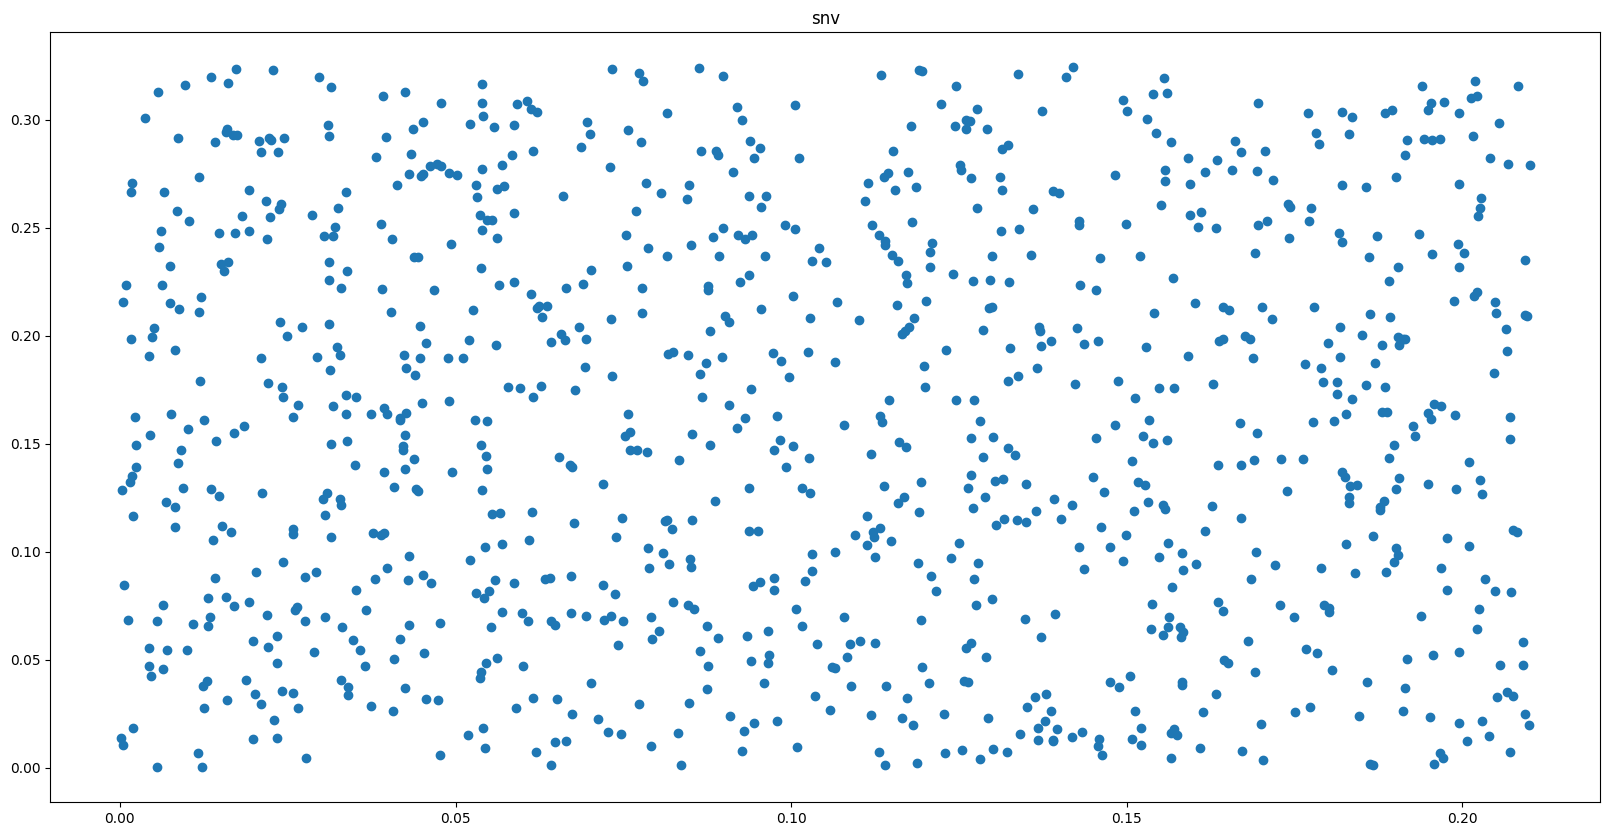

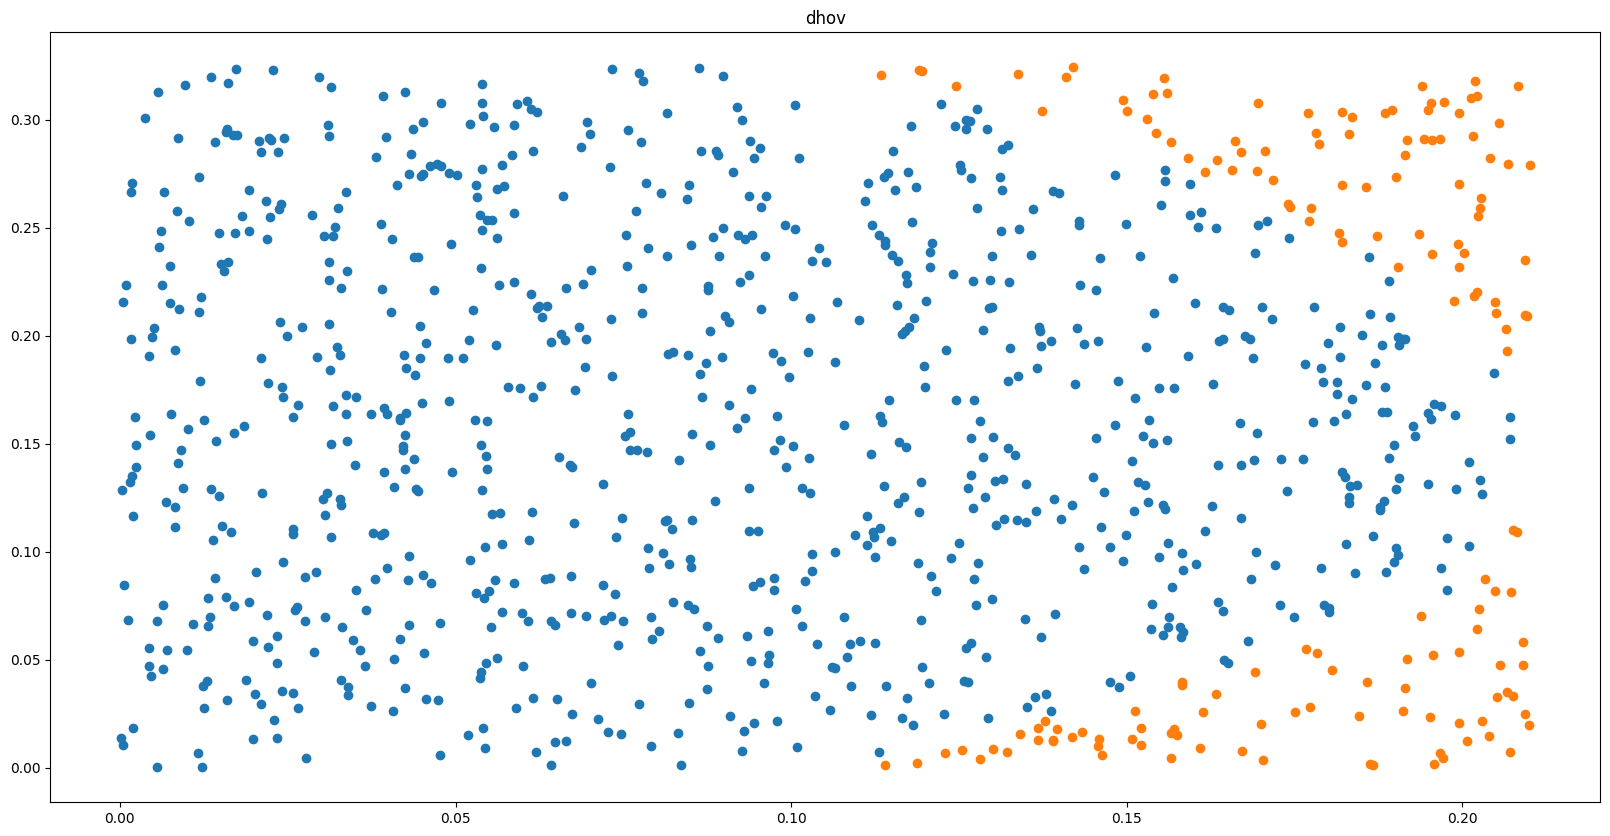

In [147]:
from script.DHOV import DataSampling as ds
snv_copy = snv_model.copy()
dhov_copy = dhov_verifier.nn_encoding_model.copy()

icnn_neuron_name_1 = "output_layer_[0]_[1]"
icnn_neuron_name_23 = "output_layer_[0]_[23]"
neuron_name_1 = "relu_var0[1]"
neuron_name_23 = "relu_var0[23]"
test_space = torch.empty((0, 2), dtype=data_type).to(device)
lower = dhov_verifier.bounds_layer_out[0][0][[1, 23]]
upper = dhov_verifier.bounds_layer_out[0][1][[1, 23]]
box_bound_output_space = ds.samples_uniform_over(test_space, 1000, [lower, upper])
print(box_bound_output_space[0])
in_snv = []
in_dhov = []
for i, sample in enumerate(box_bound_output_space):
    if i % 100 == 0:
        print(i)

    dhov_copy = dhov_verifier.nn_encoding_model.copy()
    neuron_1 = dhov_copy.getVarByName(icnn_neuron_name_1)
    neuron_23 = dhov_copy.getVarByName(icnn_neuron_name_23)
    dhov_copy.addConstr(neuron_1 == sample[0], name="n1")
    dhov_copy.addConstr(neuron_23 == sample[1], name="n2")

    dhov_copy.update()
    dhov_copy.setObjective(neuron_1, grp.GRB.MINIMIZE)
    dhov_copy.optimize()

    is_valid = False
    if dhov_copy.Status == grp.GRB.OPTIMAL:
        is_valid = True
    if dhov_copy.Status == grp.GRB.INFEASIBLE:
        print("INFEASIBLE, not ICNN(x) <= 0")

    in_dhov.append(is_valid)

    snv_copy = snv_model.copy()
    neuron_1 = snv_copy.getVarByName(neuron_name_1)
    neuron_23 = snv_copy.getVarByName(neuron_name_23)
    snv_copy.addConstr(neuron_1 == sample[0])
    snv_copy.addConstr(neuron_23 == sample[1])

    snv_copy.update()
    snv_copy.setObjective(neuron_1, grp.GRB.MINIMIZE)
    snv_copy.optimize()

    is_valid = False
    if snv_copy.Status == grp.GRB.OPTIMAL:
        is_valid = True
    in_snv.append(is_valid)

plt_inc_amb("snv", box_bound_output_space.detach().cpu().numpy(), in_snv)
plt_inc_amb("dhov", box_bound_output_space.detach().cpu().numpy(), in_dhov)

In [91]:
neuron_index = 1
icnn_neuron_name = "output_layer_[{}]_[{}]".format(layer_index, neuron_index)
neuron_name = "relu_var{}[{}]".format(2*layer_index, neuron_index)
print(icnn_neuron_name)
print(neuron_name)
# neuron_name = "last_affine_var[{}]".format(neuron_index)

output_layer_[1]_[1]
relu_var2[1]


In [92]:
dhov_copy = dhov_verifier.nn_encoding_model.copy()
dhov_copy.Params.LogToConsole = 0
add_min_constr(dhov_copy, icnn_neuron_name)
dhov_copy.update()

"""dhov_copy.computeIIS()
print("constraint")
all_constr = dhov_copy.getConstrs()

for const in all_constr:
    if const.IISConstr:
        print("{}".format(const))

print("lower bound")
all_var = dhov_copy.getVars()
for var in all_var:
    if var.IISLB:
        print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

print("upper bound")
all_var = dhov_copy.getVars()
for var in all_var:
    if var.IISUB:
        print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))"""

optimize_model(dhov_copy, icnn_neuron_name)

opt value: 5.387121523113279


5.387121523113279

In [93]:
dhov_copy = dhov_verifier.nn_encoding_model.copy()
dhov_copy.Params.LogToConsole = 0
"""neuron = dhov_copy.getVarByName(icnn_neuron_name)
dhov_copy.addConstr(neuron == 0.5622137652362753)"""
add_max_constr(dhov_copy, icnn_neuron_name)
optimize_model(dhov_copy, icnn_neuron_name)

opt value: 6.394899672483449


6.394899672483449

In [94]:
nn_input_as_lp = []
for i in range(parameter_list[0].shape[1]):
    nn_input_as_lp.append(dhov_copy.getVarByName("output_layer_[-1]_[{}]".format(i)).getAttr("x"))
nn_input_as_lp = torch.tensor(nn_input_as_lp, dtype=data_type).to(device)

neuron_value_in_lp = []
for layer_index in range(0, len(parameter_list) // 2):
    current_layer_as_lp = []
    for i in range(parameter_list[layer_index * 2].shape[0]):
        current_layer_as_lp.append(dhov_copy.getVarByName("output_layer_[{}]_[{}]".format(layer_index, i)).getAttr("x"))
    neuron_value_in_lp.append(torch.tensor(current_layer_as_lp, dtype=data_type).to(device))

In [95]:
"""flt = torch.flatten(test_image)
print(nn_input_as_lp[0].item())
nn_input_as_lp = torch.where(nn_input_as_lp > flt + eps + 1e-5, flt + eps, nn_input_as_lp)
nn_input_as_lp = torch.where(nn_input_as_lp < flt - eps - 1e-5, flt - eps, nn_input_as_lp)
print(nn_input_as_lp[0].item())"""

'flt = torch.flatten(test_image)\nprint(nn_input_as_lp[0].item())\nnn_input_as_lp = torch.where(nn_input_as_lp > flt + eps + 1e-5, flt + eps, nn_input_as_lp)\nnn_input_as_lp = torch.where(nn_input_as_lp < flt - eps - 1e-5, flt - eps, nn_input_as_lp)\nprint(nn_input_as_lp[0].item())'

In [96]:
nn_input_as_lp = torch.unsqueeze(nn_input_as_lp, dim=0)
print(nn(nn_input_as_lp))

tensor([[  0.6907,   1.7487,   0.2060,   9.5380, -13.3507,  11.5984,  -3.3209,
           1.7492,  -3.9203,  -2.6320]], dtype=torch.float64,
       grad_fn=<AddmmBackward0>)


In [97]:
as_tensor = torch.tensor(dhov_verifier.all_group_indices[0], dtype=torch.long)
as_tensor = torch.flatten(as_tensor).numpy()
print(neuron_value_in_lp[0][as_tensor])

tensor([0.1992, 0.0918, 0.0408, 0.0657, 0.0166, 0.0681, 0.0854, 0.1532, 0.3799,
        0.2992, 0.0000, 0.0000, 0.2050, 0.0260, 0.2542, 0.4534],
       dtype=torch.float64)


In [103]:
all_vars = dhov_copy.getVars()
for var in all_vars:
    print("{} : {}".format(var.getAttr("varname"), var.getAttr("x")))

output_layer_[-1]_[0] : -1.02
output_layer_[-1]_[1] : -1.02
output_layer_[-1]_[2] : -1.02
output_layer_[-1]_[3] : -0.98
output_layer_[-1]_[4] : -1.02
output_layer_[-1]_[5] : -0.98
output_layer_[-1]_[6] : -0.98
output_layer_[-1]_[7] : -0.98
output_layer_[-1]_[8] : -0.98
output_layer_[-1]_[9] : -1.02
output_layer_[-1]_[10] : -1.02
output_layer_[-1]_[11] : -0.98
output_layer_[-1]_[12] : -0.98
output_layer_[-1]_[13] : -1.02
output_layer_[-1]_[14] : -0.98
output_layer_[-1]_[15] : -1.02
output_layer_[-1]_[16] : -1.02
output_layer_[-1]_[17] : -0.98
output_layer_[-1]_[18] : -1.02
output_layer_[-1]_[19] : -0.98
output_layer_[-1]_[20] : -0.98
output_layer_[-1]_[21] : -0.98
output_layer_[-1]_[22] : -1.02
output_layer_[-1]_[23] : -1.02
output_layer_[-1]_[24] : -0.98
output_layer_[-1]_[25] : -0.98
output_layer_[-1]_[26] : -0.98
output_layer_[-1]_[27] : -0.98
output_layer_[-1]_[28] : -1.02
output_layer_[-1]_[29] : -0.98
output_layer_[-1]_[30] : -0.98
output_layer_[-1]_[31] : -1.02
output_layer_[-1]_

Test for SNV

In [99]:
snv_verifier = SingleNeuronVerifier(nn, test_image, eps, print_log=False)
snv_verifier.generate_constraints_for_net()
snv_model = snv_verifier.model
snv_model.update()
print(neuron_name)

relu_var2[1]


In [100]:
snv_copy = snv_model.copy()
snv_copy.Params.LogToConsole = 0
add_min_constr(snv_copy, neuron_name)
optimize_model(snv_copy, neuron_name)

opt value: 5.383171373708494


5.383171373708494

In [101]:
snv_copy = snv_model.copy()
snv_copy.Params.LogToConsole = 0
add_max_constr(snv_copy, neuron_name)
optimize_model(snv_copy, neuron_name)

opt value: 6.394899672483447


6.394899672483447

In [102]:
output_of_non_fixed = []
for i in as_tensor:
    output_of_non_fixed.append(round(snv_copy.getVarByName("relu_var0[{}]".format(i)).getAttr("x"), 4))
print(output_of_non_fixed)

[0.1992, 0.0918, 0.0408, 0.0657, 0.0166, 0.0681, 0.0854, 0.1532, 0.3799, 0.2992, 0.0, 0.0, 0.205, 0.026, 0.2542, 0.4534]


In [23]:
all_vars = snv_copy.getVars()
for var in all_vars:
    print("{} : {}".format(var.getAttr("varname"), var.getAttr("x")))

in_var[0] : -1.01
in_var[1] : -1.01
in_var[2] : -0.99
in_var[3] : -0.99
in_var[4] : -1.01
in_var[5] : -1.01
in_var[6] : -0.99
in_var[7] : -0.99
in_var[8] : -0.99
in_var[9] : -0.99
in_var[10] : -0.99
in_var[11] : -0.99
in_var[12] : -1.01
in_var[13] : -0.99
in_var[14] : -0.99
in_var[15] : -1.01
in_var[16] : -0.99
in_var[17] : -0.99
in_var[18] : -1.01
in_var[19] : -0.99
in_var[20] : -0.99
in_var[21] : -1.01
in_var[22] : -1.01
in_var[23] : -1.01
in_var[24] : -1.01
in_var[25] : -1.01
in_var[26] : -0.99
in_var[27] : -1.01
in_var[28] : -1.01
in_var[29] : -0.99
in_var[30] : -1.01
in_var[31] : -1.01
in_var[32] : -1.01
in_var[33] : -0.99
in_var[34] : -1.01
in_var[35] : -0.99
in_var[36] : -1.01
in_var[37] : -1.01
in_var[38] : -1.01
in_var[39] : -1.01
in_var[40] : -1.01
in_var[41] : -0.99
in_var[42] : -0.99
in_var[43] : -1.01
in_var[44] : -1.01
in_var[45] : -0.99
in_var[46] : -1.01
in_var[47] : -0.99
in_var[48] : -1.01
in_var[49] : -0.99
in_var[50] : -1.01
in_var[51] : -1.01
in_var[52] : -0.99
in_

Test for MILP

In [26]:
milp_verifier = MILPVerifier(nn, test_image, eps, print_log=False)
milp_verifier.generate_constraints_for_net(until_layer_neuron=[layer_index, neuron_index])
milp_model = milp_verifier.model
milp_model.update()

"""all_var = milp_model.getVars()
for var in all_var:
    print(var)"""


'all_var = milp_model.getVars()\nfor var in all_var:\n    print(var)'

In [27]:
milp_copy = milp_model.copy()
milp_copy.Params.LogToConsole = 0
add_min_constr(milp_copy, neuron_name)
optimize_model(milp_copy, neuron_name)

opt value: 0.0


In [28]:
milp_copy = milp_model.copy()
milp_copy.Params.LogToConsole = 0

"""fixed_neurons = [1, 23, 25, 51, 86, 96]
for index in range(100):
    milp_var = milp_copy.getVarByName("relu_var0[{}]".format(index))
    milp_copy.addConstr(milp_var == dhov_copy.getVarByName("output_layer_[0]_[{}]".format(index)).getAttr("x"))"""
add_max_constr(milp_copy, neuron_name)
optimize_model(milp_copy, neuron_name)

opt value: 0.5622137404960269


In [29]:
output_of_non_fixed = []
for i in as_tensor:
    output_of_non_fixed.append(round(milp_copy.getVarByName("relu_var0[{}]".format(i)).getAttr("x"), 4))
print(output_of_non_fixed)

[0.0, 0.1579, 0.1643, 0.1197, 0.0581, 0.0874, 0.0, 0.0716]


In [30]:
nn_input_milp= []
for i in range(parameter_list[0].shape[1]):
    nn_input_milp.append(milp_copy.getVarByName("in_var[{}]".format(i)).getAttr("x"))

In [31]:
all_vars = milp_copy.getVars()
for var in all_vars:
    print("{} : {}".format(var.getAttr("varname"), var.getAttr("x")))

in_var[0] : -1.01
in_var[1] : -1.01
in_var[2] : -0.99
in_var[3] : -0.99
in_var[4] : -1.01
in_var[5] : -1.01
in_var[6] : -0.99
in_var[7] : -0.99
in_var[8] : -0.99
in_var[9] : -0.99
in_var[10] : -0.99
in_var[11] : -0.99
in_var[12] : -1.01
in_var[13] : -0.99
in_var[14] : -0.99
in_var[15] : -1.01
in_var[16] : -0.99
in_var[17] : -0.99
in_var[18] : -1.01
in_var[19] : -0.99
in_var[20] : -0.99
in_var[21] : -1.01
in_var[22] : -1.01
in_var[23] : -1.01
in_var[24] : -1.01
in_var[25] : -1.01
in_var[26] : -0.99
in_var[27] : -1.01
in_var[28] : -1.01
in_var[29] : -0.99
in_var[30] : -1.01
in_var[31] : -1.01
in_var[32] : -1.01
in_var[33] : -0.99
in_var[34] : -1.01
in_var[35] : -0.99
in_var[36] : -1.01
in_var[37] : -1.01
in_var[38] : -1.01
in_var[39] : -1.01
in_var[40] : -1.01
in_var[41] : -0.99
in_var[42] : -0.99
in_var[43] : -1.01
in_var[44] : -1.01
in_var[45] : -0.99
in_var[46] : -1.01
in_var[47] : -0.99
in_var[48] : -1.01
in_var[49] : -0.99
in_var[50] : -1.01
in_var[51] : -1.01
in_var[52] : -0.99
in_

In [33]:
dhov_copy = dhov_verifier.nn_encoding_model.copy()
dhov_copy.Params.LogToConsole = 0
for index in range(100):
    dhov_var = milp_copy.getVarByName("output_layer_[0]_[{}]".format(index))
    milp_copy.addConstr(dhov_var == milp_copy.getVarByName("relu_var0[{}]".format(index))) #nn_input_milp[index]
add_max_constr(dhov_copy, icnn_neuron_name)
optimize_model(dhov_copy, icnn_neuron_name)

opt value: 0.5311637286930829


In [42]:
nn_input_milp = torch.tensor(nn_input_milp, dtype=data_type)
layer_0 = torch.matmul(parameter_list[0], nn_input_milp).add(parameter_list[1])
relu_0 = torch.nn.ReLU()(layer_0)
layer_1 = torch.matmul(parameter_list[2], relu_0).add(parameter_list[3])
print(layer_1)

tensor([ 0.5622,  5.8829,  1.5250, -3.3748,  1.9779, -0.9429,  0.7452, -0.2541,
         2.2339,  1.0210,  1.7514,  3.4973,  2.4593, -1.1550, -0.8883,  5.9632,
         0.6167,  3.3430, -0.8186,  5.6432,  0.2598,  6.4190,  2.1272,  5.3496,
         7.6800, -0.5891,  4.6769,  4.7965,  1.4821,  4.0188],
       dtype=torch.float64, grad_fn=<AddBackward0>)


C:\Users\Ufuk\AppData\Local\Temp\ipykernel_22172\1238379707.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nn_input_milp = torch.tensor(nn_input_milp, dtype=data_type)


In [49]:
layer_0 = torch.matmul(parameter_list[0], nn_input_as_lp).add(parameter_list[1])
relu_0 = torch.nn.ReLU()(layer_0)
layer_1 = torch.matmul(parameter_list[2], relu_0).add(parameter_list[3])
print(layer_1)

tensor([ 0.5312,  5.8599,  1.5397, -3.3681,  1.9775, -0.9555,  0.7543, -0.2534,
         2.2397,  1.0119,  1.7363,  3.4947,  2.4864, -1.1590, -0.8903,  5.9642,
         0.6028,  3.3285, -0.8213,  5.6242,  0.2798,  6.4064,  2.1499,  5.3879,
         7.6601, -0.5927,  4.6674,  4.8085,  1.4723,  3.9900],
       dtype=torch.float64, grad_fn=<AddBackward0>)
